In [1]:
import os
import sys
import time
import pandas as pd
import pyzed.sl as sl
import cv2
import json
from omegaconf import OmegaConf
from tqdm import tqdm
import numpy as np

from vision.misc.help_func import get_repo_dir, write_json, load_json, read_json
from vision.tools.video_wrapper import video_wrapper
from vision.tools.manual_slicer import slice_to_trees

repo_dir = get_repo_dir()
sys.path.append(os.path.join(repo_dir, 'vision', 'detector', 'yolo_x'))

from vision.pipelines.detection_flow import counter_detection
from vision.data.results_collector import ResultsCollector
from vision.tools.translation import translation as T
from vision.depth.slicer.slicer_flow import post_process
from vision.tools.sensors_alignment import SensorAligner
from vision.tools.camera import is_sturated
from vision.feature_extractor.feature_extractor import create_row_features_fe_pipe
import matplotlib.pyplot as plt
from vision.visualization.drawer import draw_rectangle, draw_text, draw_highlighted_test, get_color
import seaborn as sns
from vision.feature_extractor.image_processing import make_ndvi, ndvi_to_binary

In [2]:
def post_process_slice_df(slice_df):
    """
    Post processes the slices dataframe - if not all frames of the tree are on the json file they are not
        added to the data frame, this function fills in the missing trees with start and end value of -1

    Args:
        slice_df (pd.DataFrame): A dataframe contatining frame_id, tree_id, start, end

    Returns:
        (pd.DataFrame): A post process dataframe
    """
    row_to_add = []
    for tree_id in slice_df["tree_id"].unique():
        temp_df = slice_df[slice_df["tree_id"] == tree_id]
        min_frame, max_frame = temp_df["frame_id"].min(), temp_df["frame_id"].max()
        temp_df_frames = temp_df["frame_id"].values
        for frame_id in range(min_frame, max_frame +1):
            if frame_id not in temp_df_frames:
                row_to_add.append({"frame_id": frame_id, "tree_id": tree_id, "start": -1 ,"end": -1})
    return pd.concat([slice_df, pd.DataFrame.from_records(row_to_add)]).sort_values("frame_id")

In [39]:
agg_res = pd.read_csv("/media/fruitspec-lab/cam175/customers/CHILEAPP/apples_summary_tagged.csv")
agg_res_full_trees = agg_res[agg_res["full tree"]]
agg_res_full_trees.mean()

/tmp/ipykernel_6572/2333310560.py:3: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  agg_res_full_trees.mean()


0     CHILEAPP_Bloc20B_R10A_T1
1     CHILEAPP_Bloc20B_R10B_T1
2      CHILEAPP_Bloc20B_R5A_T1
3      CHILEAPP_Bloc20B_R5A_T2
4      CHILEAPP_Bloc20B_R5B_T1
5      CHILEAPP_Bloc20B_R5B_T2
6     CHILEAPP_Block12_R10A_T1
7     CHILEAPP_Block12_R10B_T1
8     CHILEAPP_Block12_R15A_T1
9     CHILEAPP_Block12_R15B_T1
10    CHILEAPP_Block12_R20A_T1
11    CHILEAPP_Block12_R20B_T1
12    CHILEAPP_Block12_R25A_T1
13    CHILEAPP_Block12_R25B_T1
14    CHILEAPP_Block12_R30A_T1
15    CHILEAPP_Block12_R30B_T1
16    CHILEAPP_Block18_R30A_T1
18    CHILEAPP_Block18_R34A_T1
20    CHILEAPP_Block18_R38A_T1
22    CHILEAPP_Block18_R42A_T1
25    CHILEAPP_Block18_R50B_T1
26    CHILEAPP_Block18_R54A_T1
30    CHILEAPP_blok13A_R27A_T1
31    CHILEAPP_blok13A_R27B_T1
32    CHILEAPP_blok13A_R33A_T1
33    CHILEAPP_blok13A_R33B_T1
36    CHILEAPP_blok13A_R43A_T1
37    CHILEAPP_blok13A_R43B_T1
38    CHILEAPP_blok13A_R48A_T1
39    CHILEAPP_blok13A_R48B_T1
41    CHILEAPP_blok20c_R10B_T1
Name: full_name, dtype: object

In [8]:
agg_res.mean()

/tmp/ipykernel_6572/1104005287.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  agg_res.mean()


cv2/F        0.868261
cv3/F        0.651957
cv4/F        0.536522
full tree    0.673913
dtype: float64

In [100]:
full_trees_cv_f = agg_res_full_trees.groupby("backrow").mean().loc[["very low", "low", "medium", "high"]].drop("full tree", axis = 1)
full_trees_cv_f.columns = [f"{col}_full" for col in full_trees_cv_f.columns]
full_trees_cv_f

/tmp/ipykernel_6572/1360138594.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  full_trees_cv_f = agg_res_full_trees.groupby("backrow").std().loc[["very low", "low", "medium", "high"]].drop("full tree", axis = 1)


,cv2/F_full,cv3/F_full,cv4/F_full
backrow,,,
very low,0.258399,0.195627,0.165892
low,0.212184,0.136560,0.122615
medium,0.139898,0.077171,0.075214
high,NaN,NaN,NaN


In [101]:
all_trees_cv_f = agg_res.groupby("backrow").mean().loc[["very low", "low", "medium", "high"]].drop("full tree", axis = 1)
all_trees_cv_f

/tmp/ipykernel_6572/2768912074.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  all_trees_cv_f = agg_res.groupby("backrow").std().loc[["very low", "low", "medium", "high"]].drop("full tree", axis = 1)


,cv2/F,cv3/F,cv4/F
backrow,,,
very low,0.228406,0.189108,0.173556
low,0.210528,0.127718,0.123009
medium,0.172030,0.077100,0.070848
high,0.447921,0.351568,0.264575


In [102]:
pd.concat([all_trees_cv_f, full_trees_cv_f], axis = 1).round(2).to_csv("/media/fruitspec-lab/cam175/customers/CHILEAPP/apples_summary_agg.csv")

In [20]:
f_df = pd.read_csv("/media/fruitspec-lab/cam175/F_dfs/CHILEAPP_F.csv")
samp2 = pd.read_csv("/media/fruitspec-lab/cam175/customers/CHILEAPP/filtered_cv_samp2.csv")
samp3 = pd.read_csv("/media/fruitspec-lab/cam175/customers/CHILEAPP/filtered_cv_samp3.csv")
samp4 = pd.read_csv("/media/fruitspec-lab/cam175/customers/CHILEAPP/filtered_cv_samp4.csv")
samp2_floorfilter = pd.read_csv("/media/fruitspec-lab/cam175/customers/CHILEAPP/filtered_cv_samp2_floorfilter.csv")
samp3_floorfilter = pd.read_csv("/media/fruitspec-lab/cam175/customers/CHILEAPP/filtered_cv_samp3_floorfilter.csv")
samp4_floorfilter = pd.read_csv("/media/fruitspec-lab/cam175/customers/CHILEAPP/filtered_cv_samp4_floorfilter.csv")
area50 = pd.read_csv("/media/fruitspec-lab/cam175/customers/CHILEAPP/filtered_cv_area50.csv")
area100 = pd.read_csv("/media/fruitspec-lab/cam175/customers/CHILEAPP/filtered_cv_area100.csv")
area150 = pd.read_csv("/media/fruitspec-lab/cam175/customers/CHILEAPP/filtered_cv_area150.csv")

In [21]:
for df in [samp2, samp3, samp4, f_df, area50, area100, area150, 
          samp2_floorfilter, samp3_floorfilter, samp4_floorfilter]:
    df["full_name"] = df["customer_name"].str.cat(df["block_name"].str.cat(df["tree_name"], sep="_"), sep="_")
    

In [22]:
samp2_merge = f_df.merge(samp2, on = "full_name")
samp3_merge = f_df.merge(samp3, on = "full_name")
samp4_merge = f_df.merge(samp4, on = "full_name")
samp2_merge_floorfilter = f_df.merge(samp2_floorfilter, on = "full_name")
samp3_merge_floorfilter = f_df.merge(samp3_floorfilter, on = "full_name")
samp4_merge_floorfilter = f_df.merge(samp4_floorfilter, on = "full_name")
area50_merge = f_df.merge(area50, on = "full_name")
area100_merge = f_df.merge(area100, on = "full_name")
area150_merge = f_df.merge(area150, on = "full_name")

In [23]:
out_frame = samp2_merge[["full_name","F", "block_name_x"]]
out_frame["cv2"] = samp2_merge_floorfilter["cv"]
out_frame["cv3"] = samp3_merge_floorfilter["cv"]
out_frame["cv4"] = samp4_merge_floorfilter["cv"]
cv_fs = []
for i in range(2,5):
    col_name = f"cv{i}/F"
    out_frame[col_name] = out_frame[f"cv{i}"]/ out_frame["F"]
    cv_fs.append(col_name)
out_frame.groupby("full_name")[cv_fs].mean().round(2).to_csv(os.path.join("/media/fruitspec-lab/cam175/customers/CHILEAPP",
                                                                  "apples_summary.csv"))

/tmp/ipykernel_6572/2069482410.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out_frame["cv2"] = samp2_merge_floorfilter["cv"]
/tmp/ipykernel_6572/2069482410.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out_frame["cv3"] = samp3_merge_floorfilter["cv"]
/tmp/ipykernel_6572/2069482410.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

In [24]:
(samp2_merge["cv"] / samp2_merge["F"]).mean()

0.885629218024085

In [25]:
(samp2_merge_floorfilter["cv"] / samp2_merge_floorfilter["F"]).mean()

0.8684570438698287

In [26]:
(samp3_merge["cv"] / samp3_merge["F"]).mean()

0.6634807571888605

In [27]:
(samp3_merge_floorfilter["cv"] / samp3_merge_floorfilter["F"]).mean()

0.6518660458890791

In [73]:
# samp3_merge_floorfilter.sort_values("block_name_x")

In [29]:
samp3_merge_floorfilter["cv/F"] = samp3_merge_floorfilter["cv"] / samp3_merge_floorfilter["F"]
samp3_merge_floorfilter.sort_values("cv/F").groupby("block_name_x")["cv/F"].mean()

block_name_x
Bloc20B    0.956458
Block12    0.629043
Block18    0.631034
blok13A    0.596451
blok20c    0.526279
Name: cv/F, dtype: float64

In [30]:
(samp4_merge["cv"] / samp4_merge["F"]).mean()

0.5446413726972277

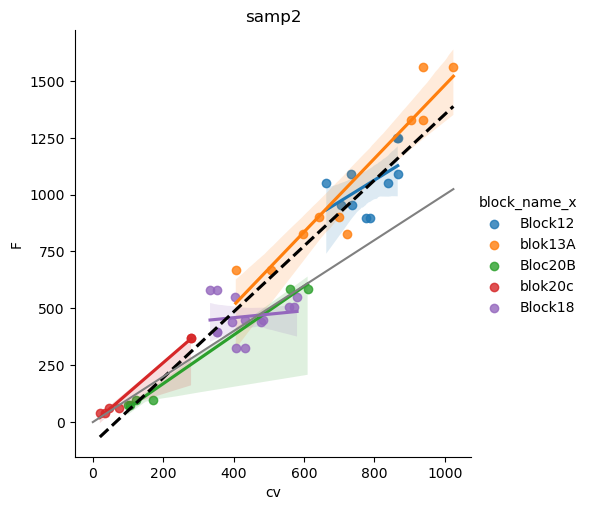

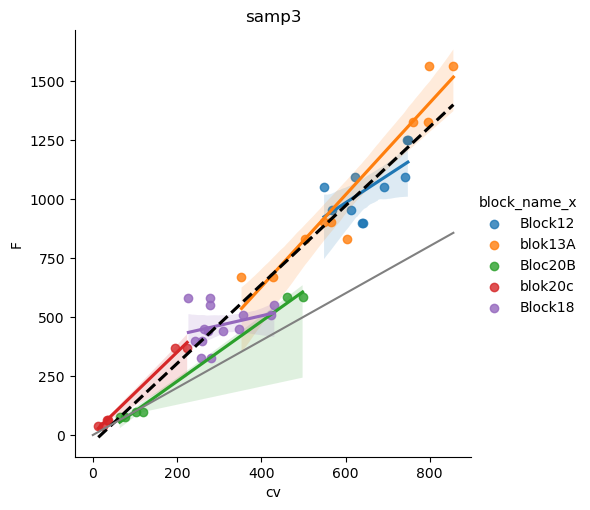

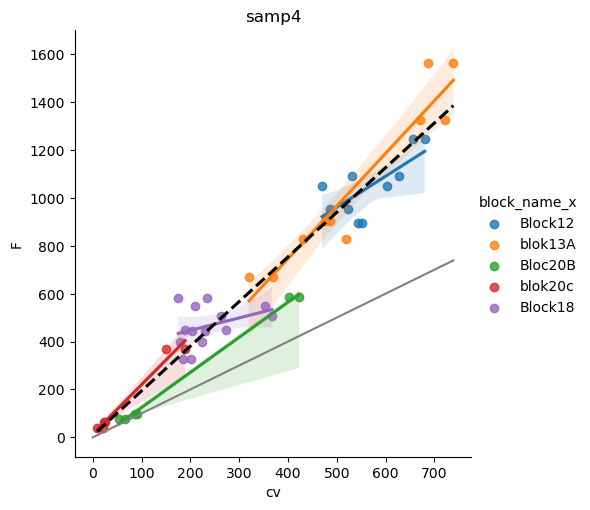

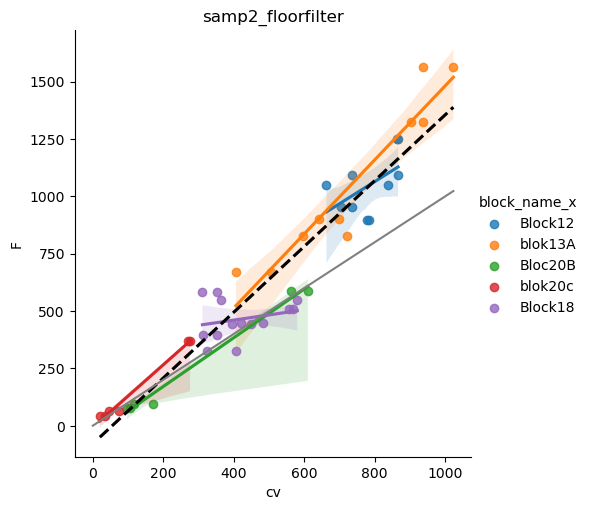

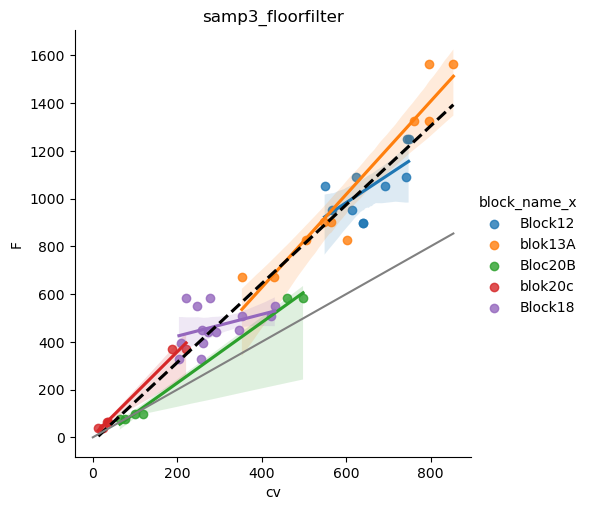

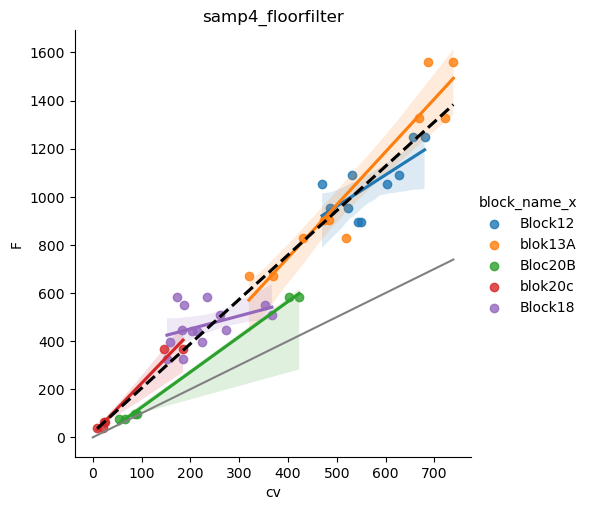

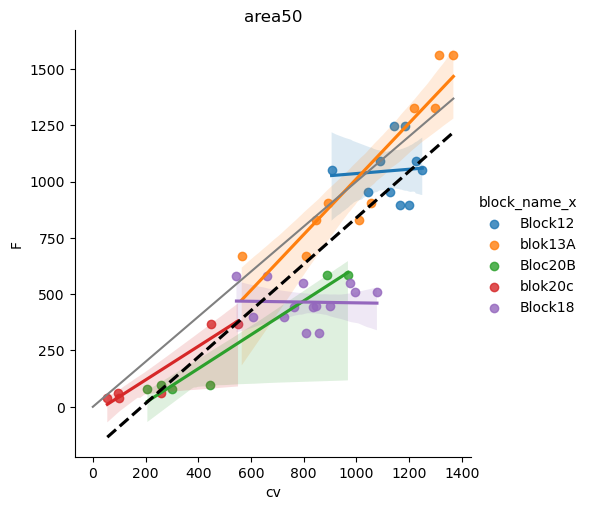

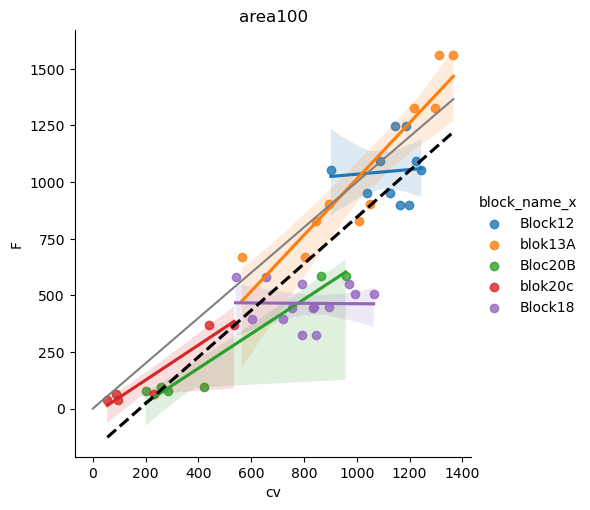

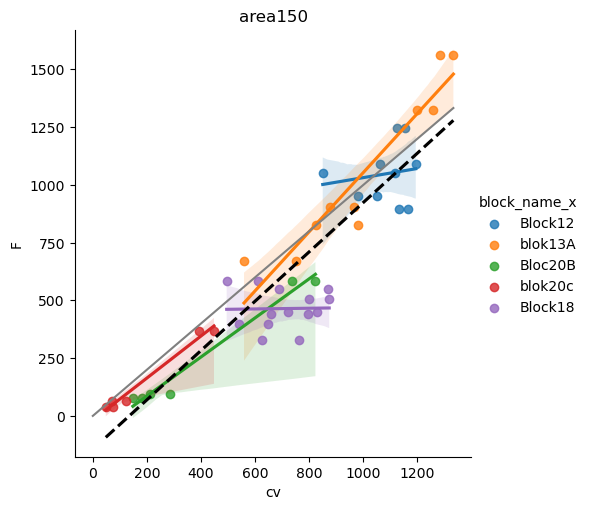

In [31]:
def plot_F_cv(df, hue = None, title= ""):
    max_val = np.min(np.max(df[["cv", "F"]].values, axis = 0))
    ax = sns.lmplot(data = df, x = "cv", y="F", hue = hue)
    sns.regplot(data = df, x = "cv", y="F", scatter_kws={'s':2}, order = 1,ci=0, ax=ax.axes[0,0],
               x_ci = 0, color = "black", line_kws={"ls":"--"},scatter=False)
    plt.plot([0, max_val], [0, max_val], color='grey')
    plt.title(title)
    plt.show()
plot_F_cv(samp2_merge,"block_name_x", "samp2")
plot_F_cv(samp3_merge,"block_name_x", "samp3")
plot_F_cv(samp4_merge,"block_name_x", "samp4")
plot_F_cv(samp2_merge_floorfilter,"block_name_x", "samp2_floorfilter")
plot_F_cv(samp3_merge_floorfilter,"block_name_x", "samp3_floorfilter")
plot_F_cv(samp4_merge_floorfilter,"block_name_x", "samp4_floorfilter")
plot_F_cv(area50_merge,"block_name_x", "area50")
plot_F_cv(area100_merge,"block_name_x", "area100")
plot_F_cv(area150_merge,"block_name_x", "area150")

In [106]:
from MHS.scoring import cross_validate_with_mean
from sklearn.linear_model import LinearRegression, PoissonRegressor

class MaxLinearRegressor(LinearRegression):
    def predict(self, X):
        predicted_values = super().predict(X)
        return np.array([max(p, 0) for p in predicted_values])

df = samp3_merge
groups = df["block_name_x"]
only_fulls = True

if only_fulls:
    valids_vec = df["full_name"].isin(agg_res_full_trees["full_name"])
    df = df[valids_vec].reset_index(drop=True)
    groups = groups[valids_vec].reset_index(drop=True)

X = df[["cv"]]
# X["cv^2"] = X["cv"]**2
y = df["F"]
# model = LinearRegression(fit_intercept = False)
model = MaxLinearRegressor()
y_pred = cross_validate_with_mean(model, X, y, groups=groups, ret_preds=True)
cross_validate_with_mean(model, X, y, groups=groups)

true: 10480,    pred: 10279.90287945619. (1.91 %) (Block12)
true: 7454,    pred: 7000.708810639771. (6.08 %) (blok13A)
true: 2926,    pred: 3093.259486887676. (5.72 %) (Block18)
true: 1516,    pred: 2012.64606632482. (32.76 %) (Bloc20B)
true: 369,    pred: 311.8056499210494. (15.50 %) (blok20c)
0.17542497046582425 0.10472401635880434
true: 10480,    pred: 10279.90287945619. (1.91 %) (Block12)
true: 7454,    pred: 7000.708810639771. (6.08 %) (blok13A)
true: 2926,    pred: 3093.259486887676. (5.72 %) (Block18)
true: 1516,    pred: 2012.64606632482. (32.76 %) (Bloc20B)
true: 369,    pred: 311.8056499210494. (15.50 %) (blok20c)
0.17542497046582425 0.10472401635880434


(0.12393388268365438, 0.11124780013110563)

In [ ]:
df = samp3_merge_floorfilter
groups = df["block_name_x"]
X = df[["cv"]]
# X["cv^2"] = X["cv"]**2
y = df["F"]
model = LinearRegression(fit_intercept = False)
y_pred = cross_validate_with_mean(model, X, y, groups=groups, ret_preds=True)
cross_validate_with_mean(model, X, y, groups=groups)

In [ ]:
cols = ["full_name", "cv", "F", "F/cv", "pred"]
samp3_merge["pred"] = y_pred
samp3_merge["err"] = (samp3_merge["pred"] - samp3_merge["F"])/samp3_merge["F"]
samp3_merge["F/cv"] = samp3_merge["F"]/samp3_merge["cv"]
samp3_merge[samp3_merge["block_name_x"].isin(["Block18"]) ].sort_values("F/cv")[cols]

In [ ]:
samp3_merge[samp3_merge["block_name_x"].isin(["Block18"]) ].sort_values("err")[cols + ["err"]]

In [ ]:
plt.hist(samp3_merge["err"].values)
plt.show()

In [ ]:
samp3_merge.sort_values("err")[cols + ["err"]]

### config

In [ ]:
row = "/media/fruitspec-lab/cam175/LIMETEST/230323/limetest/R83B"
block_name = os.path.basename(os.path.dirname(row))
row_name = os.path.basename(row)
tree_id = 2
rotate = True
t_index=6

### load data

In [ ]:
side = 1 if row.endswith("A") else 2
jai_cam = video_wrapper(os.path.join(row, f"Result_FSI_{side}.mkv"), rotate)
ret, frame = jai_cam.get_frame(1)

In [ ]:
df_tracks = pd.read_csv(os.path.join(row, "tracks.csv"))
df_slices = pd.read_csv(os.path.join(row, "slices.csv"))
df_slices = post_process_slice_df(df_slices)

In [ ]:
df_tracks

In [ ]:
df_slices

### preprocess

In [ ]:
tree_slice = df_slices[df_slices["tree_id"] == tree_id]
min_frame, max_frame = tree_slice["frame_id"].min(), tree_slice["frame_id"].max()

In [ ]:
tree_tracks = df_tracks[(df_tracks["frame"] >= min_frame) & (df_tracks["frame"] <= max_frame)]
unique_tracks = tree_tracks["track_id"].unique()
new_ids = dict(zip(unique_tracks, range(len(unique_tracks))))
tree_tracks.loc[:, "track_id"] = tree_tracks["track_id"].map(new_ids)

In [ ]:
tree_tracks["width"] = tree_tracks["x2"] - tree_tracks["x1"]
tree_tracks["height"] = tree_tracks["y2"] - tree_tracks["y1"]
tree_tracks["area"] = tree_tracks["width"] * tree_tracks["height"]
tree_tracks_groups_by_id = tree_tracks.groupby("track_id")

In [ ]:
def avg_speed(df):
    x1 = df["x1"].values
    frames = df["frame"].values
    if len(x1) == 1:
        return np.inf
    return np.mean(np.abs((x1[1:] - x1[:-1]) / (frames[1:] - frames[:-1])))
    
tracks_speed = tree_tracks_groups_by_id.apply(avg_speed)
track_id_counts = tree_tracks_groups_by_id.size()
mean_area = tree_tracks_groups_by_id["area"].mean().astype(int)
mean_width = tree_tracks_groups_by_id["width"].mean().astype(int)
mean_height = tree_tracks_groups_by_id["height"].mean().astype(int)

### histograms anaylsis

In [ ]:
sns.histplot(tree_tracks_groups_by_id.size(), bins = 100, kde=True)
plt.show()

In [ ]:
sns.histplot(mean_width, bins = 100, kde=True)
plt.show()

In [ ]:
sns.histplot(mean_height, bins = 100, kde=True)
plt.show()

In [ ]:
g = sns.histplot(mean_area, bins = 100, kde=True)
# g.set_xticks(np.arange(0,2500,100))
# plt.xticks(rotation=45)
plt.show()

In [ ]:
sns.histplot(tracks_speed, bins = 200, kde=True)
plt.show()

### plotting 

In [ ]:
import numpy as np
import cupy as cp

def num_deno_nan_divide(numerator, denominator, return_numpy=True):
    if isinstance(numerator, type(np.array([]))):
        numerator = cp.array(numerator)
        denominator = cp.array(denominator)
    result = cp.empty(numerator.shape)
    denominator_no_0 = cp.not_equal(denominator, 0)
    result[denominator_no_0] = cp.divide(numerator[denominator_no_0], denominator[denominator_no_0])
    result[1-denominator_no_0] = cp.nan
    if return_numpy:
        return cp.asnumpy(result)
    else:
        return result
    
def num_deno_nan_divide_np(numerator, denominator):
    result = np.full(numerator.shape, np.nan)
    denominator_no_0 = np.abs(denominator) >= 1
    result[denominator_no_0] = numerator[denominator_no_0] / denominator[denominator_no_0]
    result[1-denominator_no_0] = np.nan
    return result

    
def make_ndvi(rgb, nir):
    """
    rgb: rgb image or red channel
    nir: nir image
    return: ndvi image
    """
    if len(rgb.shape) == 3:
        red = rgb[:, :, 0]
    else:
        red = rgb
    ndvi_img = num_deno_nan_divide_np(np.subtract(nir, red), np.add(nir, red))
    np.nan_to_num(ndvi_img, copy=False, nan=0)
    return ndvi_img

In [ ]:
def get_min_foli_index(frame):
    red, nir = frame[:,:,2].astype(np.float32), frame[:,:,0].astype(np.float32)
    ndvi = make_ndvi(red, nir)
    binary_ndvi = 1-ndvi_to_binary(ndvi, thresh=-0.1)
#     plt.imshow(binary_ndvi)
#     plt.show()
    np.sum(binary_ndvi, axis = 1)
    return np.max(np.where(np.sum(binary_ndvi, axis = 1)>250))

# get_min_foli_index()

In [ ]:
min_samples = 0
max_samples = 1000
thresholder_frame = track_id_counts
tree_slice.loc[:, "start"] = tree_slice["start"].replace(-1, 0)
tree_slice.loc[:, "end"] = tree_slice["end"].replace(-1, 10000)
folder_dump = "/media/fruitspec-lab/easystore/backgound_test"
for f_id in tree_tracks["frame"].unique():
    frame_slices = tree_slice[tree_slice["frame_id"] == f_id][["start", "end"]].astype(int).values[0]
    
    dets = tree_tracks[tree_tracks["frame"] == f_id]
    dets = dets[(dets["x1"] > frame_slices[0]) & (
                dets["x2"] < frame_slices[1])]
    dets  = dets.values
    ret, frame = jai_cam.get_frame(f_id)
    if ret:
        min_foli_index = get_min_foli_index(frame)
        frame = cv2.line(frame, (0, min_foli_index), (frame.shape[1], min_foli_index), (0, 0, 0), 5)
        
        frame = cv2.line(frame, (frame_slices[0], 0), (frame_slices[0], int(jai_cam.get_width())),
                         color=(255, 0, 0), thickness=2)
        frame = cv2.line(frame, (frame_slices[1], 0), (frame_slices[1], int(jai_cam.get_width())),
                         color=(255, 0, 0), thickness=2)
        
        for det in dets:
            
            track_id = det[t_index]
            color_id = int(track_id) % 15  # 15 is the number of colors in list
            color = get_color(color_id)
            text_color = get_color(-1)
            n_samples_det = thresholder_frame[int(track_id)]
            tag = f'ID:{int(track_id)}, {n_samples_det}'
            tag = ""
            if n_samples_det < min_samples or n_samples_det > max_samples:
                continue
            frame = draw_rectangle(frame, (int(det[0]), int(det[1])), (int(det[2]), int(det[3])), color, 3)
            frame = draw_highlighted_test(frame, tag, (det[0], det[1]), frame.shape[1], color, text_color,
                                          True, 10, 3)

        plt.figure(figsize=(15, 10))
        plt.imshow(frame[:, :, ::-1])
        plt.title(f_id)
        plt.savefig(os.path.join(folder_dump, f"res_{block_name}_{row_name}_{f_id}"))
        plt.show()

In [ ]:
asd

In [ ]:
min_samples = 3
max_samples = 1000
thresholder_frame = track_id_counts
for f_id in tree_tracks["frame"].unique()[15:-15]:
    dets = tree_tracks[tree_tracks["frame"] == f_id]
    dets  = dets.values
    frame_slices = tree_slice[tree_slice["frame_id"] == f_id][["start", "end"]].astype(int).values[0]
    ret, frame = jai_cam.get_frame(f_id)
    if ret:
        frame = cv2.line(frame, (frame_slices[0], 0), (frame_slices[0], int(jai_cam.get_width())),
                         color=(255, 0, 0), thickness=2)
        frame = cv2.line(frame, (frame_slices[1], 0), (frame_slices[1], int(jai_cam.get_width())),
                         color=(255, 0, 0), thickness=2)
        
        for det in dets:
            
            track_id = det[t_index]
            color_id = int(track_id) % 15  # 15 is the number of colors in list
            color = get_color(color_id)
            text_color = get_color(-1)
            n_samples_det = thresholder_frame[int(track_id)]
            tag = f'ID:{int(track_id)}, {n_samples_det}'
            if n_samples_det < min_samples or n_samples_det > max_samples:
                continue
            frame = draw_rectangle(frame, (int(det[0]), int(det[1])), (int(det[2]), int(det[3])), color, 3)
            frame = draw_highlighted_test(frame, tag, (det[0], det[1]), frame.shape[1], color, text_color,
                                          True, 10, 3)
        plt.figure(figsize=(15, 10))
        plt.imshow(frame[:, :, ::-1])
        plt.title(f_id)
        plt.show()

In [ ]:
min_samples = 2
max_samples = 2
thresholder_frame = track_id_counts
for f_id in tree_tracks["frame"].unique()[15:-15]:
    dets = tree_tracks[tree_tracks["frame"] == f_id]
    dets  = dets.values
    frame_slices = tree_slice[tree_slice["frame_id"] == f_id][["start", "end"]].astype(int).values[0]
    ret, frame = jai_cam.get_frame(f_id)
    if ret:
        frame = cv2.line(frame, (frame_slices[0], 0), (frame_slices[0], int(jai_cam.get_width())),
                         color=(255, 0, 0), thickness=2)
        frame = cv2.line(frame, (frame_slices[1], 0), (frame_slices[1], int(jai_cam.get_width())),
                         color=(255, 0, 0), thickness=2)
        
        for det in dets:
            
            track_id = det[t_index]
            color_id = int(track_id) % 15  # 15 is the number of colors in list
            color = get_color(color_id)
            text_color = get_color(-1)
            n_samples_det = thresholder_frame[int(track_id)]
            tag = f'ID:{int(track_id)}, {n_samples_det}'
            if n_samples_det < min_samples or n_samples_det > max_samples:
                continue
            frame = draw_rectangle(frame, (int(det[0]), int(det[1])), (int(det[2]), int(det[3])), color, 3)
            frame = draw_highlighted_test(frame, tag, (det[0], det[1]), frame.shape[1], color, text_color,
                                          True, 10, 3)
        plt.figure(figsize=(15, 10))
        plt.imshow(frame[:, :, ::-1])
        plt.title(f_id)
        plt.show()

In [ ]:
asd

In [ ]:
min_samples = 2
max_samples = 2
thresholder_frame = track_id_counts
for f_id in tree_tracks["frame"].unique()[15:-15]:
    dets = tree_tracks[tree_tracks["frame"] == f_id]
    dets  = dets.values
    frame_slices = tree_slice[tree_slice["frame_id"] == f_id][["start", "end"]].astype(int).values[0]
    ret, frame = jai_cam.get_frame(f_id)
    if ret:
        frame = cv2.line(frame, (frame_slices[0], 0), (frame_slices[0], int(jai_cam.get_width())),
                         color=(255, 0, 0), thickness=2)
        frame = cv2.line(frame, (frame_slices[1], 0), (frame_slices[1], int(jai_cam.get_width())),
                         color=(255, 0, 0), thickness=2)
        
        for det in dets:
            
            track_id = det[t_index]
            color_id = int(track_id) % 15  # 15 is the number of colors in list
            color = get_color(color_id)
            text_color = get_color(-1)
            n_samples_det = thresholder_frame[int(track_id)]
            tag = f'ID:{int(track_id)}, {n_samples_det}'
            if n_samples_det < min_samples or n_samples_det > max_samples:
                continue
            frame = draw_rectangle(frame, (int(det[0]), int(det[1])), (int(det[2]), int(det[3])), color, 3)
            frame = draw_highlighted_test(frame, tag, (det[0], det[1]), frame.shape[1], color, text_color,
                                          True, 10, 3)
        plt.figure(figsize=(15, 10))
        plt.imshow(frame[:, :, ::-1])
        plt.title(f_id)
        plt.show()

In [ ]:
min_samples = 10
max_samples = 100
thresholder_frame = mean_area
for f_id in tree_tracks["frame"].unique()[15:-15]:
    dets = tree_tracks[tree_tracks["frame"] == f_id]
    dets  = dets.values
    frame_slices = tree_slice[tree_slice["frame_id"] == f_id][["start", "end"]].astype(int).values[0]
    ret, frame = jai_cam.get_frame(f_id)
    if ret:
        frame = cv2.line(frame, (frame_slices[0], 0), (frame_slices[0], int(jai_cam.get_width())),
                         color=(255, 0, 0), thickness=2)
        frame = cv2.line(frame, (frame_slices[1], 0), (frame_slices[1], int(jai_cam.get_width())),
                         color=(255, 0, 0), thickness=2)
        
        for det in dets:
            
            track_id = det[t_index]
            color_id = int(track_id) % 15  # 15 is the number of colors in list
            color = get_color(color_id)
            text_color = get_color(-1)
            n_samples_det = thresholder_frame[int(track_id)]
            tag = f'ID:{int(track_id)}, {n_samples_det}'
            if n_samples_det < min_samples or n_samples_det > max_samples:
                continue
            frame = draw_rectangle(frame, (int(det[0]), int(det[1])), (int(det[2]), int(det[3])), color, 3)
            frame = draw_highlighted_test(frame, tag, (det[0], det[1]), frame.shape[1], color, text_color,
                                          True, 10, 3)
        plt.figure(figsize=(15, 10))
        plt.imshow(frame[:, :, ::-1])
        plt.title(f_id)
        plt.show()

In [ ]:
min_samples = 10
max_samples = 250
thresholder_frame = mean_area
for f_id in tree_tracks["frame"].unique()[15:-15]:
    dets = tree_tracks[tree_tracks["frame"] == f_id]
    dets  = dets.values
    frame_slices = tree_slice[tree_slice["frame_id"] == f_id][["start", "end"]].astype(int).values[0]
    ret, frame = jai_cam.get_frame(f_id)
    if ret:
        frame = cv2.line(frame, (frame_slices[0], 0), (frame_slices[0], int(jai_cam.get_width())),
                         color=(255, 0, 0), thickness=2)
        frame = cv2.line(frame, (frame_slices[1], 0), (frame_slices[1], int(jai_cam.get_width())),
                         color=(255, 0, 0), thickness=2)
        
        for det in dets:
            
            track_id = det[t_index]
            color_id = int(track_id) % 15  # 15 is the number of colors in list
            color = get_color(color_id)
            text_color = get_color(-1)
            n_samples_det = thresholder_frame[int(track_id)]
            tag = f'ID:{int(track_id)}, {n_samples_det}'
            if n_samples_det < min_samples or n_samples_det > max_samples:
                continue
            frame = draw_rectangle(frame, (int(det[0]), int(det[1])), (int(det[2]), int(det[3])), color, 3)
            frame = draw_highlighted_test(frame, tag, (det[0], det[1]), frame.shape[1], color, text_color,
                                          True, 10, 3)
        plt.figure(figsize=(15, 10))
        plt.imshow(frame[:, :, ::-1])
        plt.title(f_id)
        plt.show()

In [ ]:
min_samples = 55
max_samples = 115
thresholder_frame = tracks_speed
for f_id in tree_tracks["frame"].unique()[15:-15]:
    dets = tree_tracks[tree_tracks["frame"] == f_id]
    dets  = dets.values
    frame_slices = tree_slice[tree_slice["frame_id"] == f_id][["start", "end"]].astype(int).values[0]
    ret, frame = jai_cam.get_frame(f_id)
    if ret:
        frame = cv2.line(frame, (frame_slices[0], 0), (frame_slices[0], int(jai_cam.get_width())),
                         color=(255, 0, 0), thickness=2)
        frame = cv2.line(frame, (frame_slices[1], 0), (frame_slices[1], int(jai_cam.get_width())),
                         color=(255, 0, 0), thickness=2)
        
        for det in dets:
            
            track_id = det[t_index]
            color_id = int(track_id) % 15  # 15 is the number of colors in list
            color = get_color(color_id)
            text_color = get_color(-1)
            n_samples_det = thresholder_frame[int(track_id)]
            if n_samples_det < min_samples or n_samples_det > max_samples:
                continue
            n_samples_det = int(n_samples_det)
            tag = f'ID:{int(track_id)}, {n_samples_det}'
            frame = draw_rectangle(frame, (int(det[0]), int(det[1])), (int(det[2]), int(det[3])), color, 3)
            frame = draw_highlighted_test(frame, tag, (det[0], det[1]), frame.shape[1], color, text_color,
                                          True, 10, 3)
        plt.figure(figsize=(15, 10))
        plt.imshow(frame[:, :, ::-1])
        plt.title(f_id)
        plt.show()

In [ ]:
tree_tracks

In [ ]:
from tqdm import tqdm
scan_path = "/media/fruitspec-lab/cam175/customers/CHILEAPP/091222"
for block in os.listdir(scan_path):
    block_path = os.path.join(scan_path, block)
    if not os.path.isdir(block_path):
        continue
    for row in os.listdir(block_path):
        row = os.path.join(block_path, row)
        if not os.path.isdir(row):
            continue
        block_name = os.path.basename(os.path.dirname(row))
        row_name = os.path.basename(row)
        tree_id = 1
        rotate = True
        t_index=6
        df_tracks = pd.read_csv(os.path.join(row, "tracks.csv"))
        df_slices = pd.read_csv(os.path.join(row, "slices.csv"))
        df_slices = post_process_slice_df(df_slices)
        side = 1 if row.endswith("A") else 2
        jai_cam = video_wrapper(os.path.join(row, f"Result_FSI_{side}.mkv"), rotate)
        ret, frame = jai_cam.get_frame(1)
        tree_slice = df_slices[df_slices["tree_id"] == tree_id]
        min_frame, max_frame = tree_slice["frame_id"].min(), tree_slice["frame_id"].max()
        tree_tracks = df_tracks[(df_tracks["frame"] >= min_frame) & (df_tracks["frame"] <= max_frame)]
        unique_tracks = tree_tracks["track_id"].unique()
        new_ids = dict(zip(unique_tracks, range(len(unique_tracks))))
        tree_tracks.loc[:, "track_id"] = tree_tracks["track_id"].map(new_ids)
        tree_tracks["width"] = tree_tracks["x2"] - tree_tracks["x1"]
        tree_tracks["height"] = tree_tracks["y2"] - tree_tracks["y1"]
        tree_tracks["area"] = tree_tracks["width"] * tree_tracks["height"]
        tree_tracks_groups_by_id = tree_tracks.groupby("track_id")
        def avg_speed(df):
            x1 = df["x1"].values
            frames = df["frame"].values
            if len(x1) == 1:
                return np.inf
            return np.mean(np.abs((x1[1:] - x1[:-1]) / (frames[1:] - frames[:-1])))

        tracks_speed = tree_tracks_groups_by_id.apply(avg_speed)
        track_id_counts = tree_tracks_groups_by_id.size()
        mean_area = tree_tracks_groups_by_id["area"].mean().astype(int)
        mean_width = tree_tracks_groups_by_id["width"].mean().astype(int)
        mean_height = tree_tracks_groups_by_id["height"].mean().astype(int)


        min_samples = 0
        max_samples = 1000
        thresholder_frame = track_id_counts
        tree_slice.loc[:, "start"] = tree_slice["start"].replace(-1, 0)
        tree_slice.loc[:, "end"] = tree_slice["end"].replace(-1, 10000)
        folder_dump = os.path.join("/media/fruitspec-lab/easystore/backgound_test", block_name)
        if not os.path.exists(folder_dump):
            os.mkdir(folder_dump)
        for f_id in tqdm(tree_tracks["frame"].unique()):
            frame_slices = tree_slice[tree_slice["frame_id"] == f_id][["start", "end"]].astype(int).values[0]

            dets = tree_tracks[tree_tracks["frame"] == f_id]
            dets = dets[(dets["x1"] > frame_slices[0]) & (
                        dets["x2"] < frame_slices[1])]
            dets  = dets.values
            ret, frame = jai_cam.get_frame(f_id)
            if ret:
                min_foli_index = get_min_foli_index(frame)
                frame = cv2.line(frame, (0, min_foli_index), (frame.shape[1], min_foli_index), (0, 0, 0), 5)

                frame = cv2.line(frame, (frame_slices[0], 0), (frame_slices[0], int(jai_cam.get_width())),
                                 color=(255, 0, 0), thickness=2)
                frame = cv2.line(frame, (frame_slices[1], 0), (frame_slices[1], int(jai_cam.get_width())),
                                 color=(255, 0, 0), thickness=2)

                for det in dets:

                    track_id = det[t_index]
                    color_id = int(track_id) % 15  # 15 is the number of colors in list
                    color = get_color(color_id)
                    text_color = get_color(-1)
                    n_samples_det = thresholder_frame[int(track_id)]
                    tag = f'ID:{int(track_id)}, {n_samples_det}'
                    tag = f"{int(track_id)}"
                    if n_samples_det < min_samples or n_samples_det > max_samples:
                        continue
                    frame = draw_rectangle(frame, (int(det[0]), int(det[1])), (int(det[2]), int(det[3])), color, 3)
                    frame = draw_highlighted_test(frame, tag, (det[0], det[1]), frame.shape[1], color, text_color,
                                                  True, 10, 3)

                plt.figure(figsize=(15, 10))
                plt.imshow(frame[:, :, ::-1])
                plt.title(f_id)
                plt.savefig(os.path.join(folder_dump, f"res_{row_name}_T{tree_id}_{f_id}"))
                plt.close()
        jai_cam.close()